In [2]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.72 µs


In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

# レスラー方程式に外力を加える
def rossler_with_forcing(t, state, a, b, c, A):
    x, y, z = state  # stateからx、y、zの値をアンパック
    forcing = A * np.sin(t)  # 外力項
    dxdt = -y - z + forcing  # xの方程式に外力を加える
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# パラメータ
a = 0.2
b = 0.2
c = 5.7
A = 1.0  # 外力の振幅を設定
initial_state = [0.0, 0.0, 0.0]
t_span = (0, 2510)

# solve_ivpでの解
sol = solve_ivp(
    rossler_with_forcing, t_span, initial_state,
    args=(a, b, c, A),
    t_eval=np.linspace(t_span[0], t_span[1], 25100),
    max_step=0.01
)

t = sol.t
x = sol.y[0]
y = sol.y[1]
z = sol.y[2]
forcing = A * np.sin(t)  # 外力のデータ

# CSVファイルにデータを保存（外力の情報も含む）
data = pd.DataFrame({
    'Time': t,
    'X': x,
    'Y': y,
    'Z': z,
    'Forcing': forcing
})
data.to_csv('rossler_with_forcing.csv', index=False)

# CSVファイルを読み込む（外力の情報も含む）
data_loaded = pd.read_csv('rossler_with_forcing.csv')

# pandas DataFrameでXにx, y, forcingを格納
X = pd.DataFrame({'x': x, 'y': y, 'Forcing': forcing}).values
print(X.shape)  # (3, 25100) と出力されるはず


(25100, 3)


In [4]:
best = ({'N': 0,
  'iss': 0.14258024657972923,
  'lr': 0.5516837456874331,
  'ridge': 3.7433235003717447e-07,
  'seed': 0,
  'sr': 0.1931498404234262})

In [17]:
train_len = 2000 
forecast=1 
seed_timesteps = 100 
nb_generations = 400

    
from reservoirpy.datasets import to_forecasting

    
n, m = X.shape

train_len = train_len

x, y = to_forecasting(X, forecast=forecast)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

dataset = ((X_train, y_train), (X_test, y_test))

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                    sr=sr, 
                    lr=lr, 
                    input_scaling=iss, 
                    seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

In [18]:
seed_timesteps = seed_timesteps
nb_generations = 1500
#実際は150ステップに対応

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．

[-1.4158084  -3.68684143  0.46008017]:warming_out[-1]
[-1.40176192 -3.68799994  0.46030695]:X_test[seed_timesteps]


In [19]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した

(3,)
(1, 3)


In [20]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = model(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]

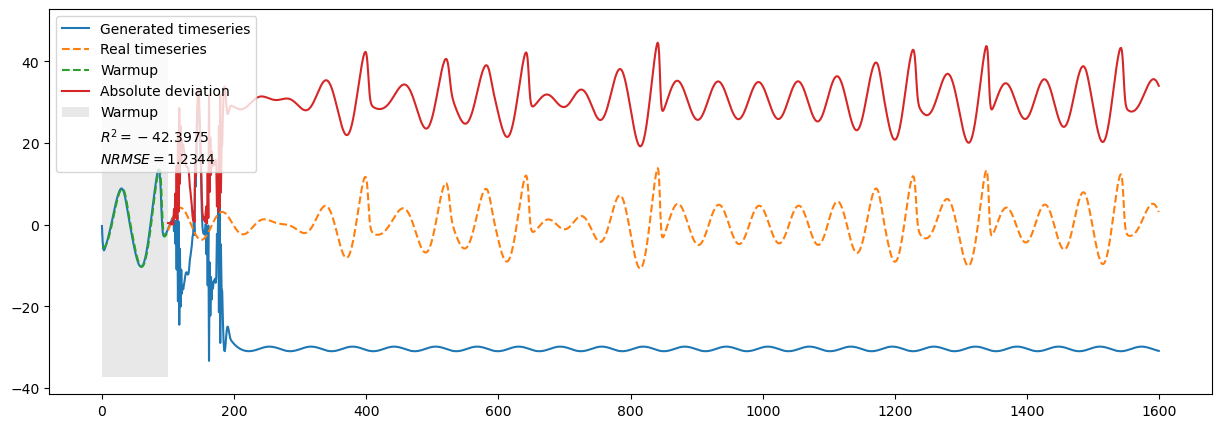

In [21]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)
